## Import the dependencies

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications import vgg16
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy

from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

## Data preparation

In [4]:
train_path  = 'data/train'
valid_path  = 'data/valid'
test_path  = 'data/test'

In [5]:
# ImageDataGenerator generates batches of tensor image data with real-time data augmentation.
# The data will be looped over (in batches).
# in this example, we won't be doing any image augmentation
train_batches = ImageDataGenerator().flow_from_directory(train_path,
                                                         target_size=(224,224),
                                                         batch_size=10)

valid_batches = ImageDataGenerator().flow_from_directory(valid_path,
                                                         target_size=(224,224),
                                                         batch_size=30)

test_batches = ImageDataGenerator().flow_from_directory(test_path,
                                                        target_size=(224,224),
                                                        batch_size=50,
                                                        shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [6]:
## Getting the base model (VGG-16)

In [7]:
base_model = vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (224,224, 3), pooling='avg')
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Freeze the base model, except 5 last layers

In [8]:
# iterate through its layers and lock them to make them not trainable with this code
for layer in base_model.layers[:-5]:
    layer.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
# use “get_layer” method to save the last layer of the network
last_layer = base_model.get_layer('global_average_pooling2d')

# save the output of the last layer to be the input of the next layer
last_output = last_layer.output

# add our new softmax layer with 3 hidden units
x = Dense(10, activation='softmax', name='softmax')(last_output)

# instantiate a new_model using keras’s Model class
new_model = Model(inputs=base_model.input, outputs=x)

# print the new_model summary
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Train the model

In [10]:
new_model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='signlanguage.model.hdf5', save_best_only=True)

history = new_model.fit_generator(train_batches, steps_per_epoch=18,
                                  validation_data=valid_batches, validation_steps=3, epochs=20, verbose=1, callbacks=[checkpointer])

/home/biba_bo/.local/lib/python3.6/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
18/18 [==============================] - 11s 423ms/step - loss: 3.0001 - accuracy: 0.2667 - val_loss: 1.8009 - val_accuracy: 0.3222
Epoch 2/20
18/18 [==============================] - 4s 224ms/step - loss: 1.1107 - accuracy: 0.6111 - val_loss: 0.6515 - val_accuracy: 0.7667
Epoch 3/20
18/18 [==============================] - 4s 233ms/step - loss: 0.5102 - accuracy: 0.8278 - val_loss: 0.4592 - val_accuracy: 0.8778
Epoch 4/20
18/18 [==============================] - 4s 231ms/step - loss: 0.3671 - accuracy: 0.8889 - val_loss: 0.3854 - val_accuracy: 0.9000
Epoch 5/20
18/18 [==============================] - 5s 271ms/step - loss: 0.2773 - accuracy: 0.9056 - val_loss: 0.4349 - val_accuracy: 0.8778
Epoch 6/20
18/18 [==============================] - 4s 241ms/step - loss: 0.1562 - accuracy: 0.9444 - val_loss: 0.3893 - val_accuracy: 0.9222
Epoch 7/20
18/18 [==============================] - 4s 232ms/step - loss: 0.0728 - accuracy: 0.9778 - val_loss: 0.3336 - val_accuracy: 0.9333
Epoch

## evaluate the model

In [12]:
scores = new_model.evaluate(test_batches, batch_size=128, verbose=1)
print('Test result: %.3f loss: %.3f' % (scores[1] * 100, scores [0]))

1/1 [==============================] - 8s 8s/step - loss: 0.0060 - accuracy: 1.0000
Test result: 100.000 loss: 0.006


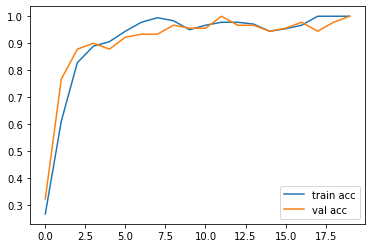

In [13]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

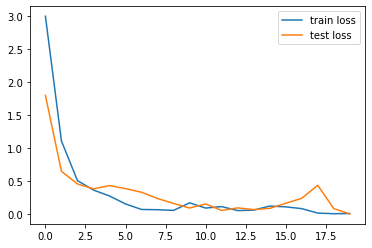

In [14]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend()
plt.show()

In [15]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np

def load_dataset(path):
    data = load_files(path)
    paths = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']))
    return paths, targets

In [17]:
test_files, test_targets = load_dataset('data/test')

In [18]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

test_tensors = preprocess_input(paths_to_tensor(test_files))

100%|██████████| 50/50 [00:00<00:00, 1190.90it/s]


In [19]:
new_model.load_weights('signlanguage.model.hdf5')

In [20]:
print('\nTesting loss: {:.4f}\nTesting accuracy: {:.4f}'.format(*new_model.evaluate(test_tensors, test_targets)))

2/2 [==============================] - 6s 3s/step - loss: 0.0411 - accuracy: 0.9800

Testing loss: 0.0411
Testing accuracy: 0.9800


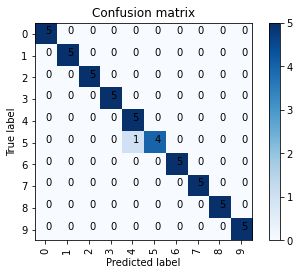

In [21]:
from sklearn.metrics import confusion_matrix

cm_labels = ['0','1','2','3','4','5','6','7','8','9']

cm = confusion_matrix(np.argmax(test_targets, axis=1),
                      np.argmax(new_model.predict(test_tensors), axis=1))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
indexes = np.arange(len(cm_labels))
for i in indexes:
    for j in indexes:
        plt.text(j, i, cm[i, j])
plt.xticks(indexes, cm_labels, rotation=90)
plt.xlabel('Predicted label')
plt.yticks(indexes, cm_labels)
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()